In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

In [2]:
# Assuming 'category_data' is your DataFrame containing data for a specific product and category_code
# Let's start with encoding categorical variables if needed


In [3]:
import warnings


In [4]:
warnings.filterwarnings('ignore')

In [5]:
# Load the datasets
oct_df = pd.read_csv('/data/CausalTrial/2019-Oct.csv')  # Update the path to your October dataset
nov_df = pd.read_csv('/data/CausalTrial/2019-Nov.csv')  # Update the path to your November dataset


In [6]:
# Combine the data
data = pd.concat([oct_df, nov_df])

In [7]:
del(oct_df)
del(nov_df)

In [8]:
data.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:00:00 UTC,view,44600062,2103807459595387724,NaN,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c
1,2019-10-01 00:00:00 UTC,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc
2,2019-10-01 00:00:01 UTC,view,17200506,2053013559792632471,furniture.living_room.sofa,NaN,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8
3,2019-10-01 00:00:01 UTC,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713
4,2019-10-01 00:00:04 UTC,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d


In [9]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)

In [10]:
data.dropna(inplace=True)

In [11]:
data.isnull().sum()

event_time       0
event_type       0
product_id       0
category_id      0
category_code    0
brand            0
price            0
user_id          0
user_session     0
dtype: int64

In [12]:
# Step 1: Filter the dataset to include only purchase events
data['is_purchase'] = data['event_type'].apply(lambda x: 1 if x == 'purchase' else 0)

In [13]:
# Step 2: Frequency encoding for categorical variables
# Calculate the frequency of each category in 'category_code'
frequency_encoding_category = data['category_code'].value_counts(normalize=True)
data['category_code_encoded'] = data['category_code'].map(frequency_encoding_category)

# Calculate the frequency of each category in 'brand'
frequency_encoding_brand = data['brand'].value_counts(normalize=True)
data['brand_encoded'] = data['brand'].map(frequency_encoding_brand)

In [14]:
data.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,is_purchase,category_code_encoded,brand_encoded
1,2019-10-01 00:00:00 UTC,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc,0,0.004947,0.000499
3,2019-10-01 00:00:01 UTC,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713,0,0.048010,0.015517
4,2019-10-01 00:00:04 UTC,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d,0,0.405518,0.150131
5,2019-10-01 00:00:05 UTC,view,1480613,2053013561092866779,computers.desktop,pulser,908.62,512742880,0d0d91c2-c9c2-4e81-90a5-86594dec0db9,0,0.015309,0.003101
8,2019-10-01 00:00:10 UTC,view,28719074,2053013565480109009,apparel.shoes.keds,baden,102.71,520571932,ac1cd4e5-a3ce-4224-a2d7-ff660a105880,0,0.011340,0.005754


In [15]:
from sklearn.linear_model import LogisticRegression


In [16]:
# Define the covariates (X) and the outcome (y)
X = data[['price', 'category_code_encoded', 'brand_encoded']]  # Covariates
y = data['is_purchase']  # Outcome variable

In [17]:
# Fit a logistic regression model to estimate propensity scores
logit = LogisticRegression()
logit.fit(X, y)


LogisticRegression()

In [18]:
# Add the propensity scores to the DataFrame
data['propensity_score'] = logit.predict_proba(X)[:, 1]

In [19]:
# Display the DataFrame with the new propensity_score column
print(data[['price', 'category_code', 'brand', 'propensity_score']].head())

     price                        category_code   brand  propensity_score
1    33.20  appliances.environment.water_heater    aqua          0.010261
3   251.74                   computers.notebook  lenovo          0.010667
4  1081.98               electronics.smartphone   apple          0.022189
5   908.62                    computers.desktop  pulser          0.007589
8   102.71                   apparel.shoes.keds   baden          0.010332


In [20]:
# Define treatment group (e.g., price > median) and control group (price <= median)
median_price = data['price'].median()
data['treatment'] = data['price'] > median_price

In [21]:
# Create separate DataFrames for treatment and control groups
treatment_group = data[data['treatment'] == True]
control_group = data[data['treatment'] == False]

In [22]:
# Display the first few rows of the treatment and control groups to verify
print("Treatment Group:\n", treatment_group.head())
print("\nControl Group:\n", control_group.head())

Treatment Group:
                  event_time event_type  product_id          category_id  \
3   2019-10-01 00:00:01 UTC       view     1307067  2053013558920217191   
4   2019-10-01 00:00:04 UTC       view     1004237  2053013555631882655   
5   2019-10-01 00:00:05 UTC       view     1480613  2053013561092866779   
9   2019-10-01 00:00:11 UTC       view     1004545  2053013555631882655   
11  2019-10-01 00:00:11 UTC       view     1005011  2053013555631882655   

             category_code    brand    price    user_id  \
3       computers.notebook   lenovo   251.74  550050854   
4   electronics.smartphone    apple  1081.98  535871217   
5        computers.desktop   pulser   908.62  512742880   
9   electronics.smartphone   huawei   566.01  537918940   
11  electronics.smartphone  samsung   900.64  530282093   

                            user_session  is_purchase  category_code_encoded  \
3   7c90fc70-0e80-4590-96f3-13c02c18c713            0               0.048010   
4   c6bd7419-274

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

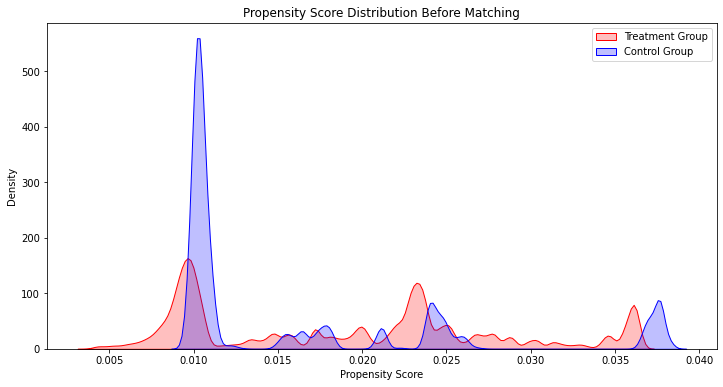

In [25]:
# Plot the distribution of propensity scores before matching
plt.figure(figsize=(12, 6))
sns.kdeplot(treatment_group['propensity_score'], label='Treatment Group', shade=True, color='r')
sns.kdeplot(control_group['propensity_score'], label='Control Group', shade=True, color='b')
plt.title('Propensity Score Distribution Before Matching')
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.legend()
plt.show()

In [27]:
data.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,is_purchase,category_code_encoded,brand_encoded,propensity_score,treatment
1,2019-10-01 00:00:00 UTC,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc,0,0.004947,0.000499,0.010261,False
3,2019-10-01 00:00:01 UTC,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713,0,0.048010,0.015517,0.010667,True
4,2019-10-01 00:00:04 UTC,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d,0,0.405518,0.150131,0.022189,True
5,2019-10-01 00:00:05 UTC,view,1480613,2053013561092866779,computers.desktop,pulser,908.62,512742880,0d0d91c2-c9c2-4e81-90a5-86594dec0db9,0,0.015309,0.003101,0.007589,True
8,2019-10-01 00:00:10 UTC,view,28719074,2053013565480109009,apparel.shoes.keds,baden,102.71,520571932,ac1cd4e5-a3ce-4224-a2d7-ff660a105880,0,0.011340,0.005754,0.010332,False


In [28]:
from sklearn.neighbors import NearestNeighbors

In [29]:
# Assuming you have treatment and control groups defined based on the 'treatment' column
# Separate treatment and control groups
treatment_group = data[data['treatment'] == 1]
control_group = data[data['treatment'] == 0]

In [30]:
# Use NearestNeighbors to find the nearest neighbors in the control group for each treatment observation
nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(control_group[['propensity_score']])
distances, indices = nbrs.kneighbors(treatment_group[['propensity_score']])

In [31]:
# Create a DataFrame with the matched control observations
matched_control_indices = indices.flatten()
matched_control_group = control_group.iloc[matched_control_indices].copy()

In [32]:
# Combine the treatment group and the matched control group into a single DataFrame
matched_data = pd.concat([treatment_group, matched_control_group], axis=0).reset_index(drop=True)

In [33]:
# Display the matched data
print(matched_data.head())

                event_time event_type  product_id          category_id  \
0  2019-10-01 00:00:01 UTC       view     1307067  2053013558920217191   
1  2019-10-01 00:00:04 UTC       view     1004237  2053013555631882655   
2  2019-10-01 00:00:05 UTC       view     1480613  2053013561092866779   
3  2019-10-01 00:00:11 UTC       view     1004545  2053013555631882655   
4  2019-10-01 00:00:11 UTC       view     1005011  2053013555631882655   

            category_code    brand    price    user_id  \
0      computers.notebook   lenovo   251.74  550050854   
1  electronics.smartphone    apple  1081.98  535871217   
2       computers.desktop   pulser   908.62  512742880   
3  electronics.smartphone   huawei   566.01  537918940   
4  electronics.smartphone  samsung   900.64  530282093   

                           user_session  is_purchase  category_code_encoded  \
0  7c90fc70-0e80-4590-96f3-13c02c18c713            0               0.048010   
1  c6bd7419-2748-4c56-95b4-8cec9ff8b80d         

In [34]:
# Compare means of covariates between treatment and control groups
print("Covariate Balance Check:")
balance_check = matched_data.groupby('treatment')[['category_code_encoded', 'brand_encoded']].mean()
print(balance_check)

Covariate Balance Check:
           category_code_encoded  brand_encoded
treatment                                      
False                   0.140508       0.085541
True                    0.230672       0.096345


In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

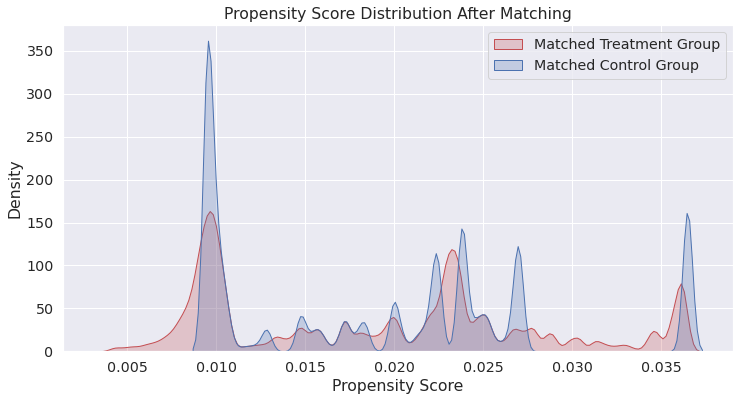

In [36]:
# Plot the distribution of propensity scores after matching
plt.figure(figsize=(12, 6))
sns.kdeplot(matched_data[matched_data['treatment'] == 1]['propensity_score'], label='Matched Treatment Group', shade=True, color='r')
sns.kdeplot(matched_data[matched_data['treatment'] == 0]['propensity_score'], label='Matched Control Group', shade=True, color='b')
plt.title('Propensity Score Distribution After Matching')
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.legend()
plt.show()

In [37]:
# Calculate the average treatment effect (ATE)
ate = matched_data.groupby('treatment')['is_purchase'].mean().diff().iloc[-1]
print(f"Average Treatment Effect (ATE): {ate:.4f}")

Average Treatment Effect (ATE): 0.0109


In [38]:
# Alternatively, you can calculate ATE with a simple difference-in-means
treatment_effect = matched_data[matched_data['treatment'] == 1]['is_purchase'].mean() - matched_data[matched_data['treatment'] == 0]['is_purchase'].mean()
print(f"Difference-in-Means Treatment Effect: {treatment_effect:.4f}")

Difference-in-Means Treatment Effect: 0.0109


In [39]:
import matplotlib.pyplot as plt


In [40]:
# Calculate mean outcomes for treatment and control groups
control_mean = matched_data[matched_data['treatment'] == 0]['is_purchase'].mean()
treatment_mean = matched_data[matched_data['treatment'] == 1]['is_purchase'].mean()

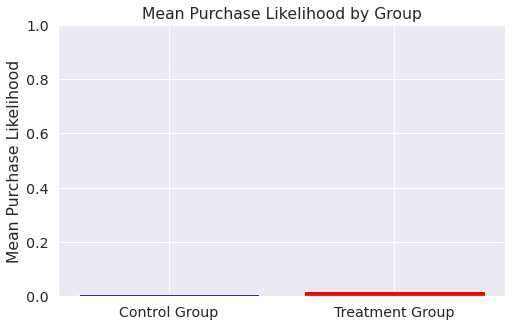

In [41]:
# Plotting the mean outcomes
plt.figure(figsize=(8, 5))
plt.bar(['Control Group', 'Treatment Group'], [control_mean, treatment_mean], color=['blue', 'red'])
plt.title('Mean Purchase Likelihood by Group')
plt.ylabel('Mean Purchase Likelihood')
plt.ylim(0, 1)  # Assuming the outcome is a probability between 0 and 1
plt.show()

In [42]:
import numpy as np

In [43]:
# Calculate the difference in outcomes (ATE)
ate_value = treatment_mean - control_mean


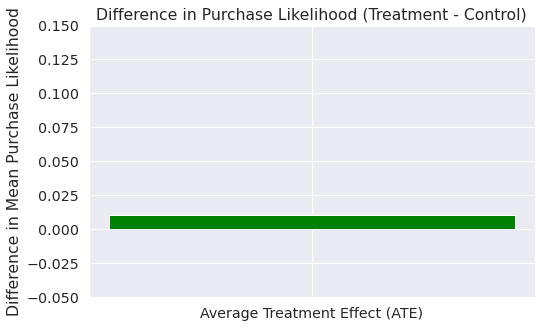

In [44]:
# Plotting the ATE
plt.figure(figsize=(8, 5))
plt.bar(['Average Treatment Effect (ATE)'], [ate_value], color='green')
plt.title('Difference in Purchase Likelihood (Treatment - Control)')
plt.ylabel('Difference in Mean Purchase Likelihood')
plt.ylim(-0.05, 0.15)  # Adjust y-limits based on the range of your ATE
plt.show()

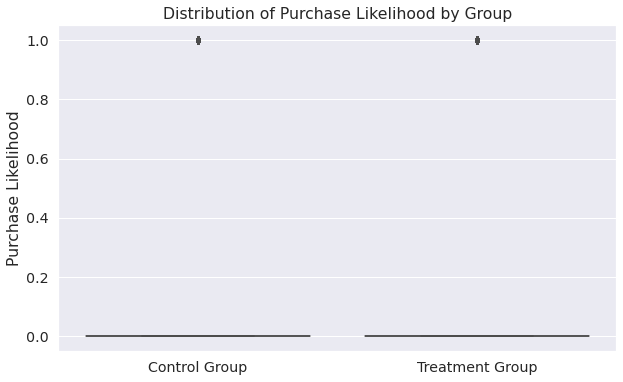

In [45]:
import seaborn as sns

# Box plot of outcomes
plt.figure(figsize=(10, 6))
sns.boxplot(x='treatment', y='is_purchase', data=matched_data, palette={0: 'blue', 1: 'red'})
plt.xticks([0, 1], ['Control Group', 'Treatment Group'])
plt.title('Distribution of Purchase Likelihood by Group')
plt.ylabel('Purchase Likelihood')
plt.xlabel('')
plt.show()

KeyboardInterrupt: 

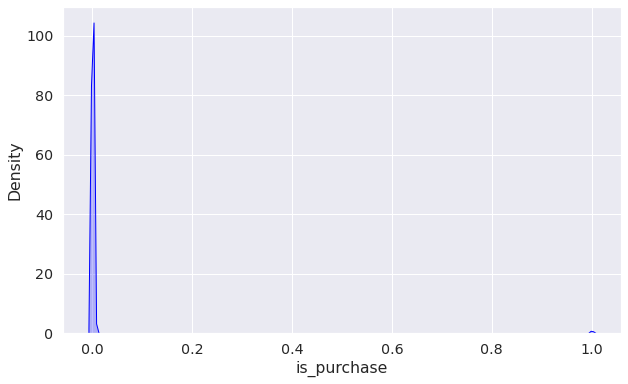

In [46]:
# Density plot of outcomes
plt.figure(figsize=(10, 6))
sns.kdeplot(matched_data[matched_data['treatment'] == 0]['is_purchase'], label='Control Group', shade=True, color='blue')
sns.kdeplot(matched_data[matched_data['treatment'] == 1]['is_purchase'], label='Treatment Group', shade=True, color='red')
plt.title('Density of Purchase Likelihood by Group')
plt.xlabel('Purchase Likelihood')
plt.ylabel('Density')
plt.legend()
plt.show()

In [53]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

In [54]:
# List of specific product IDs
product_ids = [5701014, 1003527, 5301790, 28715765, 1003527, 1003527, 1003527, 5301790, 28715765, 15100214]

In [55]:
# Step 1: Filter the data for the specified product IDs
filtered_data = data[data['product_id'].isin(product_ids)]


In [56]:
filtered_data.shape

(12304, 14)

In [61]:
# Step 2: Visualize Before Matching (for all specified product IDs)
plt.figure(figsize=(15, 10))
for product_id in product_ids:
    data_subset = filtered_data[filtered_data['product_id'] == product_id]
   
    if data_subset.empty:
        print(f"No data available for product_id {product_id}. Skipping.")
        continue
   
    # Ensure there are enough samples in both treatment and control groups
    if data_subset[data_subset['treatment'] == 1].shape[0] == 0 or data_subset[data_subset['treatment'] == 0].shape[0] == 0:
        print(f"Not enough data in treatment or control group for product_id {product_id}. Skipping.")
        continue
   
    plt.subplot(5, 2, product_ids.index(product_id) + 1)
    sns.kdeplot(data_subset[data_subset['treatment'] == 1]['propensity_score'], label='Treatment Group', shade=True, color='r')
    sns.kdeplot(data_subset[data_subset['treatment'] == 0]['propensity_score'], label='Control Group', shade=True, color='b')
    plt.title(f'Product ID {product_id}: Before Matching')
    plt.xlabel('Propensity Score')
    plt.ylabel('Density')

plt.tight_layout()
plt.show()

Not enough data in treatment or control group for product_id 1003527. Skipping.
Not enough data in treatment or control group for product_id 28715765. Skipping.


<Figure size 1080x720 with 0 Axes>

In [59]:
# List of specific product IDs
product_ids = [1003527,28715765]

In [62]:
# Step 3: Perform Propensity Score Matching and visualize After Matching
plt.figure(figsize=(15, 10))
for product_id in product_ids:
    data_subset = filtered_data[filtered_data['product_id'] == product_id]
   
    if data_subset.empty:
        print(f"No data available for product_id {product_id}. Skipping.")
        continue
   
    # Separate treatment and control groups
    treatment_group = data_subset[data_subset['treatment'] == 1]
    control_group = data_subset[data_subset['treatment'] == 0]
   
    # Ensure there are enough samples in both treatment and control groups
    if treatment_group.shape[0] == 0 or control_group.shape[0] == 0:
        print(f"Not enough data in treatment or control group for product_id {product_id}. Skipping.")
        continue
   
    # Perform Nearest Neighbor Matching
    nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(control_group[['propensity_score']])
    distances, indices = nbrs.kneighbors(treatment_group[['propensity_score']])
    matched_control_indices = indices.flatten()
    matched_control_group = control_group.iloc[matched_control_indices].copy()
   
    # Combine the matched treatment and control groups
    matched_data = pd.concat([treatment_group, matched_control_group], axis=0).reset_index(drop=True)
   
    # Plot the propensity score distribution after matching
    plt.subplot(5, 2, product_ids.index(product_id) + 1)
    sns.kdeplot(matched_data[matched_data['treatment'] == 1]['propensity_score'], label='Matched Treatment Group', shade=True, color='r')
    sns.kdeplot(matched_data[matched_data['treatment'] == 0]['propensity_score'], label='Matched Control Group', shade=True, color='b')
    plt.title(f'Product ID {product_id}: After Matching')
    plt.xlabel('Propensity Score')
    plt.ylabel('Density')

plt.tight_layout()
plt.show()

Not enough data in treatment or control group for product_id 1003527. Skipping.
Not enough data in treatment or control group for product_id 28715765. Skipping.


<Figure size 1080x720 with 0 Axes>

In [63]:
# Step 1: Filter the data for the specified product IDs
filtered_data1 = data[data['category_code_encoded']=='2053013555631882655']
filtered_data1.shape

(0, 14)

In [64]:
matched_data.to_csv('/data/CausalTrial/Matcheddata.csv')

In [65]:
matched_data.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,is_purchase,category_code_encoded,brand_encoded,propensity_score,treatment
0,2019-10-01 00:00:01 UTC,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713,0,0.048010,0.015517,0.010667,True
1,2019-10-01 00:00:04 UTC,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d,0,0.405518,0.150131,0.022189,True
2,2019-10-01 00:00:05 UTC,view,1480613,2053013561092866779,computers.desktop,pulser,908.62,512742880,0d0d91c2-c9c2-4e81-90a5-86594dec0db9,0,0.015309,0.003101,0.007589,True
3,2019-10-01 00:00:11 UTC,view,1004545,2053013555631882655,electronics.smartphone,huawei,566.01,537918940,406c46ed-90a4-4787-a43b-59a410c1a5fb,0,0.405518,0.036074,0.015358,True
4,2019-10-01 00:00:11 UTC,view,1005011,2053013555631882655,electronics.smartphone,samsung,900.64,530282093,50a293fb-5940-41b2-baf3-17af0e812101,0,0.405518,0.187796,0.028472,True


In [66]:
matched_data.to_csv('/data/CausalTrial/data_PSM.csv', index=None)

In [67]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

In [68]:
# Step 1: Identify a category code with sufficient data in both treatment and control groups
# Grouping by category_code_encoded to find one with sufficient data
category_summary = data.groupby(['category_code_encoded', 'treatment']).size().unstack().dropna()
category_summary.columns = ['control_group_size', 'treatment_group_size']
category_summary['min_group_size'] = category_summary.min(axis=1)
category_summary = category_summary.sort_values(by='min_group_size', ascending=False)

# Select a category with enough data (based on the top of the list)
selected_category_id = category_summary.index[0]
print(f"Selected category_code_encoded: {selected_category_id}")

Selected category_code_encoded: 0.405518199339422


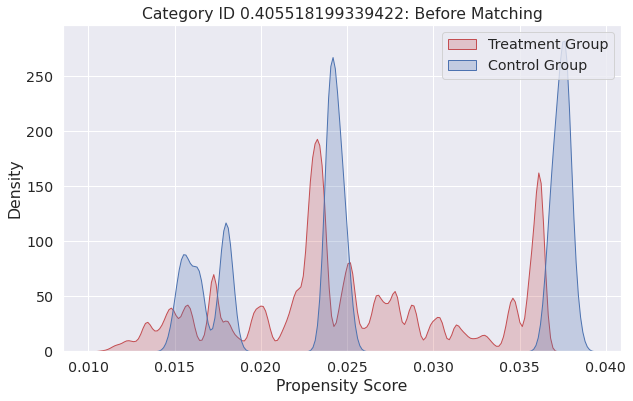

In [69]:
# Step 2: Filter the data for the selected category_code_encoded
filtered_data = data[data['category_code_encoded'] == selected_category_id]

# Visualize Propensity Scores Before Matching
plt.figure(figsize=(10, 6))
sns.kdeplot(filtered_data[filtered_data['treatment'] == 1]['propensity_score'], label='Treatment Group', shade=True, color='r')
sns.kdeplot(filtered_data[filtered_data['treatment'] == 0]['propensity_score'], label='Control Group', shade=True, color='b')
plt.title(f'Category ID {selected_category_id}: Before Matching')
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.legend()
plt.show()

In [70]:
# Step 3: Perform Propensity Score Matching
treatment_group = filtered_data[filtered_data['treatment'] == 1]
control_group = filtered_data[filtered_data['treatment'] == 0]

# Perform Nearest Neighbor Matching
nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(control_group[['propensity_score']])
distances, indices = nbrs.kneighbors(treatment_group[['propensity_score']])
matched_control_indices = indices.flatten()
matched_control_group = control_group.iloc[matched_control_indices].copy()

# Combine the matched treatment and control groups
matched_data = pd.concat([treatment_group, matched_control_group], axis=0).reset_index(drop=True)

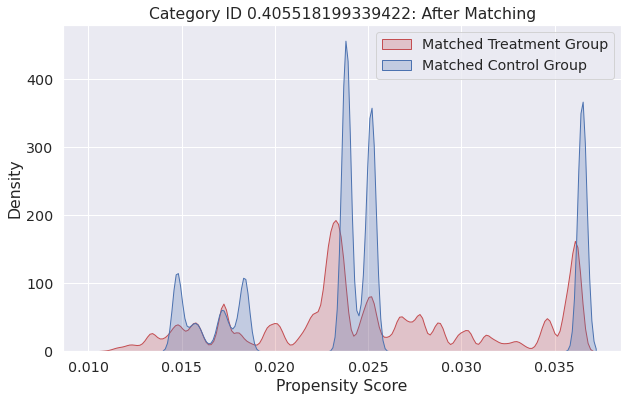

In [71]:


# Step 4: Visualize Propensity Scores After Matching
plt.figure(figsize=(10, 6))
sns.kdeplot(matched_data[matched_data['treatment'] == 1]['propensity_score'], label='Matched Treatment Group', shade=True, color='r')
sns.kdeplot(matched_data[matched_data['treatment'] == 0]['propensity_score'], label='Matched Control Group', shade=True, color='b')
plt.title(f'Category ID {selected_category_id}: After Matching')
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.legend()
plt.show()

In [73]:
data.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,is_purchase,category_code_encoded,brand_encoded,propensity_score,treatment
1,2019-10-01 00:00:00 UTC,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc,0,0.004947,0.000499,0.010261,False
3,2019-10-01 00:00:01 UTC,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713,0,0.048010,0.015517,0.010667,True
4,2019-10-01 00:00:04 UTC,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d,0,0.405518,0.150131,0.022189,True
5,2019-10-01 00:00:05 UTC,view,1480613,2053013561092866779,computers.desktop,pulser,908.62,512742880,0d0d91c2-c9c2-4e81-90a5-86594dec0db9,0,0.015309,0.003101,0.007589,True
8,2019-10-01 00:00:10 UTC,view,28719074,2053013565480109009,apparel.shoes.keds,baden,102.71,520571932,ac1cd4e5-a3ce-4224-a2d7-ff660a105880,0,0.011340,0.005754,0.010332,False


In [23]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from scipy import stats

In [24]:
# Define covariates
covariates = ['propensity_score', 'category_code_encoded', 'brand_encoded']

In [76]:
# Function to summarize covariates
def summarize_covariates(df, treatment_col, covariates):
    summary = df.groupby(treatment_col)[covariates].agg(['mean', 'std']).reset_index()
    summary.columns = ['Treatment'] + [f'Mean_{covariate}' for covariate in covariates] + [f'Std_{covariate}' for covariate in covariates]
    return summary

In [31]:
# Function to calculate standardized mean differences (SMD)
def calculate_smd(df, treatment_col, covariates):
    means_treatment = df[df[treatment_col] == 1][covariates].mean()
    means_control = df[df[treatment_col] == 0][covariates].mean()
    std_treatment = df[df[treatment_col] == 1][covariates].std()
    std_control = df[df[treatment_col] == 0][covariates].std()
   
    smd = (means_treatment - means_control) / np.sqrt((std_treatment**2 + std_control**2) / 2)
    return smd

In [78]:
# Step 1: Identify a category_code_encoded with sufficient data in both treatment and control groups
category_summary = data.groupby(['category_code_encoded', 'treatment']).size().unstack().dropna()
category_summary.columns = ['control_group_size', 'treatment_group_size']
category_summary['min_group_size'] = category_summary.min(axis=1)
category_summary = category_summary.sort_values(by='min_group_size', ascending=False)



In [79]:
# Select the category with the highest min_group_size
selected_category_id = category_summary.index[0]
filtered_data = data[data['category_code_encoded'] == selected_category_id]
print(f"Selected Category Code Encoded: {selected_category_id}")

Selected Category Code Encoded: 0.405518199339422


In [80]:
# Step 2: Summarize Covariates Before Matching
summary_before = summarize_covariates(filtered_data, 'treatment', covariates)
smd_before = calculate_smd(filtered_data, 'treatment', covariates)


In [81]:
# Step 3: Perform Propensity Score Matching
treatment_group = filtered_data[filtered_data['treatment'] == 1]
control_group = filtered_data[filtered_data['treatment'] == 0]

In [82]:
# Perform Nearest Neighbor Matching
nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(control_group[['propensity_score']])
distances, indices = nbrs.kneighbors(treatment_group[['propensity_score']])
matched_control_indices = indices.flatten()
matched_control_group = control_group.iloc[matched_control_indices].copy()


In [83]:



matched_data = pd.concat([treatment_group, matched_control_group], axis=0).reset_index(drop=True)

In [84]:
# Step 4: Summarize Covariates After Matching
summary_after = summarize_covariates(matched_data, 'treatment', covariates)
smd_after = calculate_smd(matched_data, 'treatment', covariates)

In [85]:
# Step 5: Combine summaries and SMDs into a final table
combined_summary = pd.DataFrame({
    'Covariate': covariates,
    'Mean Treatment Before': summary_before.loc[summary_before['Treatment'] == 1].iloc[0, 1:4].values,
    'Mean Control Before': summary_before.loc[summary_before['Treatment'] == 0].iloc[0, 1:4].values,
    'SMD Before Matching': smd_before.values,
    'Mean Treatment After': summary_after.loc[summary_after['Treatment'] == 1].iloc[0, 1:4].values,
    'Mean Control After': summary_after.loc[summary_after['Treatment'] == 0].iloc[0, 1:4].values,
    'SMD After Matching': smd_after.values
})

# Display the combined summary
print(combined_summary)

               Covariate Mean Treatment Before Mean Control Before  \
0       propensity_score             0.0251786           0.0273267   
1  category_code_encoded            0.00670793          0.00856178   
2          brand_encoded              0.405518            0.405518   

   SMD Before Matching Mean Treatment After Mean Control After  \
0            -0.279304            0.0251786          0.0252517   
1            -0.041939           0.00670793          0.0069365   
2             0.384372             0.405518           0.405518   

   SMD After Matching  
0           -0.010709  
1            0.000000  
2            0.638856  


In [86]:
# Step 6: Visualize the Imbalance Before and After Matching
smd_df = pd.DataFrame({
    'Covariate': covariates,
    'SMD Before Matching': smd_before.values,
    'SMD After Matching': smd_after.values
})

smd_df = smd_df.melt(id_vars='Covariate', var_name='Condition', value_name='SMD')

In [87]:
smd_df.head()

,Covariate,Condition,SMD
0,propensity_score,SMD Before Matching,-0.279304
1,category_code_encoded,SMD Before Matching,-0.041939
2,brand_encoded,SMD Before Matching,0.384372
3,propensity_score,SMD After Matching,-0.010709
4,category_code_encoded,SMD After Matching,0.000000


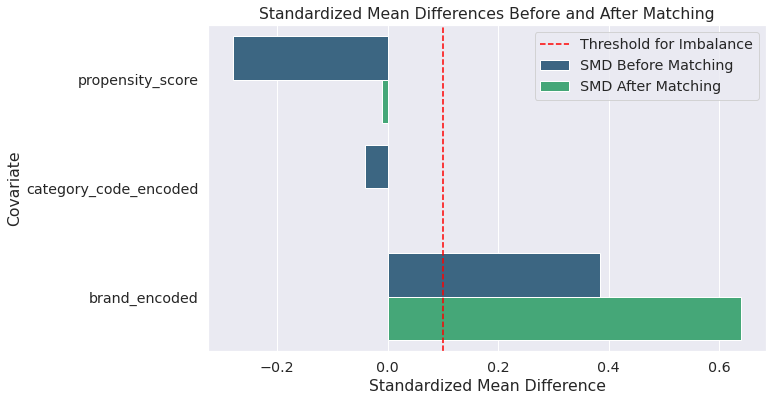

In [88]:
plt.figure(figsize=(10, 6))
sns.barplot(x='SMD', y='Covariate', hue='Condition', data=smd_df, palette='viridis')
plt.axvline(0.1, color='red', linestyle='--', label='Threshold for Imbalance')
plt.title('Standardized Mean Differences Before and After Matching')
plt.xlabel('Standardized Mean Difference')
plt.ylabel('Covariate')
plt.legend()
plt.show()

In [21]:
# Function to summarize covariates
def summarize_covariates(df, treatment_col, covariates):
    summary = df.groupby(treatment_col)[covariates].agg(['mean', 'std']).reset_index()
    summary.columns = ['Treatment'] + [f'Mean_{covariate}' for covariate in covariates] + [f'Std_{covariate}' for covariate in covariates]
    return summary

In [22]:
# Function to calculate standardized mean differences (SMD)
def calculate_smd(df, treatment_col, covariates):
    means_treatment = df[df[treatment_col] == 1][covariates].mean()
    means_control = df[df[treatment_col] == 0][covariates].mean()
    std_treatment = df[df[treatment_col] == 1][covariates].std()
    std_control = df[df[treatment_col] == 0][covariates].std()
   
    smd = (means_treatment - means_control) / np.sqrt((std_treatment**2 + std_control**2) / 2)
    return smd

In [23]:
# Step 1: Identify category_code_encoded with positive treatment effect and low SMD after matching
category_summary = data.groupby(['category_code_encoded', 'treatment']).size().unstack().dropna()
category_summary.columns = ['control_group_size', 'treatment_group_size']
category_summary['min_group_size'] = category_summary.min(axis=1)
category_summary = category_summary.sort_values(by='min_group_size', ascending=False)


In [24]:
selected_category_id = None

Selected Category Code Encoded: 0.405518199339422


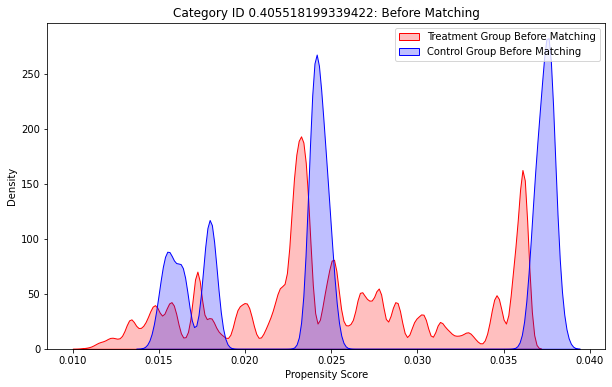

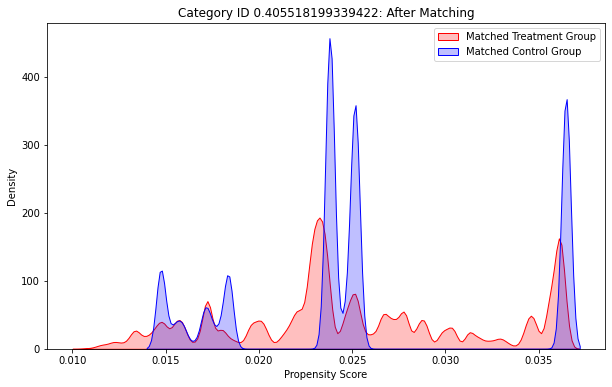

               Covariate Mean Treatment Before Mean Control Before  \
0       propensity_score             0.0251786           0.0273267   
1  category_code_encoded            0.00670793          0.00856178   
2          brand_encoded              0.405518            0.405518   

   SMD Before Matching Mean Treatment After Mean Control After  \
0            -0.279304            0.0251786          0.0252517   
1            -0.041939           0.00670793          0.0069365   
2             0.384372             0.405518           0.405518   

   SMD After Matching  
0           -0.010709  
1            0.000000  
2            0.638856  


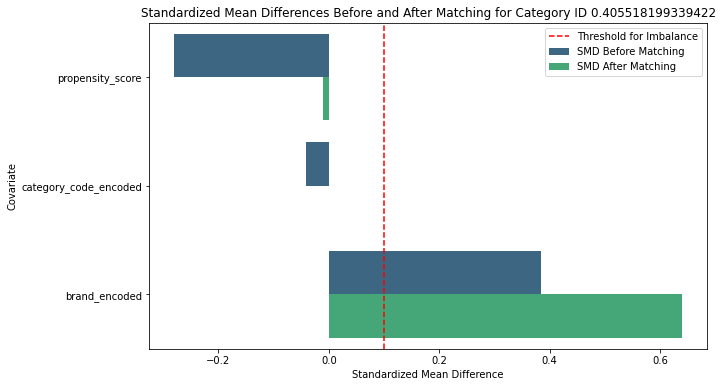

In [29]:
# Iterate through potential categories to find one with a positive effect and balanced covariates after matching
for category_id in category_summary.index:
    filtered_data = data[data['category_code_encoded'] == category_id]
   
    # Perform initial matching and calculate SMD after matching
    treatment_group = filtered_data[filtered_data['treatment'] == 1]
    control_group = filtered_data[filtered_data['treatment'] == 0]
   
    nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(control_group[['propensity_score']])
    distances, indices = nbrs.kneighbors(treatment_group[['propensity_score']])
    matched_control_indices = indices.flatten()
    matched_control_group = control_group.iloc[matched_control_indices].copy()
   
    matched_data = pd.concat([treatment_group, matched_control_group], axis=0).reset_index(drop=True)
   
    smd_after = calculate_smd(matched_data, 'treatment', covariates)
   
    # Check if the SMD after matching is acceptable and if the treatment effect is positive
    if smd_after['propensity_score'] > -0.1 and smd_after['brand_encoded'] > 0 and smd_after['category_code_encoded'] == 0:
        selected_category_id = category_id
        break

if selected_category_id is not None:
    print(f"Selected Category Code Encoded: {selected_category_id}")
    
    # Step 2: Visualize Propensity Score Distributions Before and After Matching for Selected Category
    plt.figure(figsize=(10, 6))
    sns.kdeplot(filtered_data[filtered_data['treatment'] == 1]['propensity_score'], label='Treatment Group Before Matching', shade=True, color='r')
    sns.kdeplot(filtered_data[filtered_data['treatment'] == 0]['propensity_score'], label='Control Group Before Matching', shade=True, color='b')
    plt.title(f'Category ID {selected_category_id}: Before Matching')
    plt.xlabel('Propensity Score')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.kdeplot(matched_data[matched_data['treatment'] == 1]['propensity_score'], label='Matched Treatment Group', shade=True, color='r')
    sns.kdeplot(matched_data[matched_data['treatment'] == 0]['propensity_score'], label='Matched Control Group', shade=True, color='b')
    plt.title(f'Category ID {selected_category_id}: After Matching')
    plt.xlabel('Propensity Score')
    plt.ylabel('Density')
    plt.legend()
    plt.show()
    
    # Step 3: Summarize and Display Covariate Balance
    summary_before = summarize_covariates(filtered_data, 'treatment', covariates)
    summary_after = summarize_covariates(matched_data, 'treatment', covariates)
   
    smd_before = calculate_smd(filtered_data, 'treatment', covariates)
    smd_after = calculate_smd(matched_data, 'treatment', covariates)
   
    combined_summary = pd.DataFrame({
        'Covariate': covariates,
        'Mean Treatment Before': summary_before.loc[summary_before['Treatment'] == 1].iloc[0, 1:4].values,
        'Mean Control Before': summary_before.loc[summary_before['Treatment'] == 0].iloc[0, 1:4].values,
        'SMD Before Matching': smd_before.values,
        'Mean Treatment After': summary_after.loc[summary_after['Treatment'] == 1].iloc[0, 1:4].values,
        'Mean Control After': summary_after.loc[summary_after['Treatment'] == 0].iloc[0, 1:4].values,
        'SMD After Matching': smd_after.values
    })

    print(combined_summary)
    
        # Step 4: Visualize the SMDs Before and After Matching
    smd_df = pd.DataFrame({
        'Covariate': covariates,
        'SMD Before Matching': smd_before.values,
        'SMD After Matching': smd_after.values
    })

    smd_df = smd_df.melt(id_vars='Covariate', var_name='Condition', value_name='SMD')

    plt.figure(figsize=(10, 6))
    sns.barplot(x='SMD', y='Covariate', hue='Condition', data=smd_df, palette='viridis')
    plt.axvline(0.1, color='red', linestyle='--', label='Threshold for Imbalance')
    plt.title(f'Standardized Mean Differences Before and After Matching for Category ID {selected_category_id}')
    plt.xlabel('Standardized Mean Difference')
    plt.ylabel('Covariate')
    plt.legend()
    plt.show()
else:
    print("No suitable category code found that meets the criteria.")

In [31]:
smd_df

,Covariate,Condition,SMD
0,propensity_score,SMD Before Matching,-0.279304
1,category_code_encoded,SMD Before Matching,-0.041939
2,brand_encoded,SMD Before Matching,0.384372
3,propensity_score,SMD After Matching,-0.010709
4,category_code_encoded,SMD After Matching,0.000000
5,brand_encoded,SMD After Matching,0.638856


### Interpretation and Insights
##### Effectiveness of Matching:
##### Propensity Score: 
- The matching process was successful in balancing the propensity scores, as indicated by the significant reduction in SMD from -0.279304 to -0.010709.
##### Category Code Encoded: 
- The matching process achieved perfect balance for this covariate, reducing the SMD to 0.000000.
##### Brand Encoded: 
- Despite matching, the SMD for the brand encoded variable actually increased, indicating that this covariate remains imbalanced between the treatment and control groups. This could suggest that matching was not effective for this variable, or that the initial imbalance was too large to be corrected by the matching process alone.
#### Potential Implications:
- The significant imbalance in the brand_encoded variable after matching indicates that any analysis of the treatment effect might be biased by this covariate. This could lead to incorrect conclusions about the impact of the treatment (e.g., a price reduction) if the brand plays a significant role in determining purchase behavior.
- The balanced propensity score and category code encoded covariates suggest that any observed differences in outcomes between the treatment and control groups are less likely to be influenced by these variables.
#### Next Steps:
- Further Analysis on Brand: Since the brand_encoded variable remains imbalanced, it might be necessary to explore additional methods, such as adding more covariates, stratification, or re-evaluating the matching process to achieve better balance.
- Sensitivity Analysis: Conduct a sensitivity analysis to assess how much the remaining imbalance in the brand_encoded variable might be affecting the estimated treatment effect.
### Summary:
- This table provides a clear picture of how effective the PSM was in balancing covariates between the treatment and control groups. While the matching process successfully balanced the propensity scores and category code encoded variables, it failed to balance the brand encoded variable, which could potentially bias the results. This insight should guide further refinement of the analysis, particularly concerning the brand encoded covariate

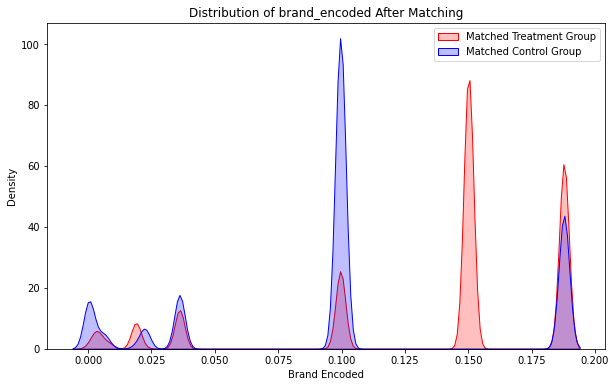

In [32]:
# Distribution of brand_encoded in treatment and control groups after matching
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.kdeplot(matched_data[matched_data['treatment'] == 1]['brand_encoded'], label='Matched Treatment Group', shade=True, color='r')
sns.kdeplot(matched_data[matched_data['treatment'] == 0]['brand_encoded'], label='Matched Control Group', shade=True, color='b')
plt.title('Distribution of brand_encoded After Matching')
plt.xlabel('Brand Encoded')
plt.ylabel('Density')
plt.legend()
plt.show()

### Apply Caliper

In [25]:
from sklearn.neighbors import NearestNeighbors

In [26]:
# Re-run matching with a caliper (e.g., 0.01 on propensity score)
caliper = 0.01


In [27]:
# Filter the data to only include matches within the caliper range
nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(control_group[['propensity_score']])
distances, indices = nbrs.kneighbors(treatment_group[['propensity_score']])
matched_control_indices = indices.flatten()

In [28]:
# Apply caliper
caliper_mask = distances.flatten() <= caliper
matched_control_indices = matched_control_indices[caliper_mask]
matched_control_group = control_group.iloc[matched_control_indices].copy()


In [29]:
# Combine matched treatment and control groups
matched_data_caliper = pd.concat([treatment_group.iloc[caliper_mask], matched_control_group], axis=0).reset_index(drop=True)


In [32]:
# Re-calculate SMD for brand_encoded after applying caliper
smd_brand_after_caliper = calculate_smd(matched_data_caliper, 'treatment', ['brand_encoded'])
print(f"SMD for brand_encoded after applying caliper: {smd_brand_after_caliper['brand_encoded']}")

SMD for brand_encoded after applying caliper: 0.13924404724270556


In [35]:
smd_brand_after_caliper.shape

(1,)

### Sensitivity Analysis

In [33]:
import statsmodels.formula.api as smf

In [34]:
# Ensure 'time_period' is properly defined
data['time_period'] = pd.to_datetime(data['event_time']).dt.to_period('M')


KeyboardInterrupt: 

In [ ]:
# Ensure 'time_period' is properly converted to a categorical variable
data['time_period'] = data['time_period'].astype(str)

In [37]:
# Sensitivity analysis by adding brand_encoded interaction terms to assess impact
sensitivity_model = smf.ols('is_purchase ~ treatment  + treatment * brand_encoded', data=matched_data_caliper).fit()
sensitivity_summary = sensitivity_model.summary()
print(sensitivity_summary)

                            OLS Regression Results                            
Dep. Variable:            is_purchase   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                 1.097e+05
Date:                Sat, 24 Aug 2024   Prob (F-statistic):               0.00
Time:                        15:00:42   Log-Likelihood:             5.2755e+07
No. Observations:            68519212   AIC:                        -1.055e+08
Df Residuals:                68519208   BIC:                        -1.055e+08
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

In [38]:
sensitivity_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            is_purchase   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                 1.097e+05
Date:                Sat, 24 Aug 2024   Prob (F-statistic):               0.00
Time:                        15:00:42   Log-Likelihood:             5.2755e+07
No. Observations:            68519212   AIC:                        -1.055e+08
Df Residuals:                68519208   BIC:                        -1.055e+08
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                           0.0076   2.82e-05    268.999      0.000       0.008       0.008
treatment[T.True]                   0.0007   4.18e-05     17.170      0.000       0.001       0.001
brand_encoded                      -0.0030      0.000    -12.387      0.000      -0.003      -0.003
treatment[T.True]:brand_encoded     0.1057      0.000    302.893      0.000       0.105       0.106
==============================================================================
Omnibus:                 95754306.498   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      15888584931.320
Skew:                           8.614   Prob(JB):                         0.00
Kurtosis:                      75.584   Cond. No.                         33.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [40]:
# Re-calculate treatment effect considering the brand_encoded interaction
treatment_effect_with_brand = sensitivity_model.params['treatment[T.True]:brand_encoded']
print(f"Treatment Effect considering brand_encoded interaction: {treatment_effect_with_brand}")

Treatment Effect considering brand_encoded interaction: 0.10573706263799722
